In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

## Load the dataset

In [2]:
from DatasetHandler import DatasetHandler

### 1. Initialize the dataset handler

In [3]:
datasetHandler = DatasetHandler('EuroSAT')
datasetHandler.print_classes()

Classes: 
     Class 0 -> EuroSAT/Forest
     Class 1 -> EuroSAT/River
     Class 2 -> EuroSAT/Highway
     Class 3 -> EuroSAT/AnnualCrop
     Class 4 -> EuroSAT/SeaLake
     Class 5 -> EuroSAT/HerbaceousVegetation
     Class 6 -> EuroSAT/Industrial
     Class 7 -> EuroSAT/Residential
     Class 8 -> EuroSAT/PermanentCrop
     Class 9 -> EuroSAT/Pasture


### 2. Select the two classes for the binary classification

In [4]:
class_1 = 0 #int(input('Class 1 [0-9]: '))
class_2 = 1 #int(input('Class 2 [0-9]: '))
print(datasetHandler.classes[class_1])
print(datasetHandler.classes[class_2])

classes_name = []
classes_name.append(datasetHandler.classes[class_1].split('/')[-1])
classes_name.append(datasetHandler.classes[class_2].split('/')[-1])

EuroSAT/Forest
EuroSAT/River


### 3. Load paths and labels

In [5]:
imgs_path, imgs_label = datasetHandler.load_paths_labels(classes = [datasetHandler.classes[class_1], datasetHandler.classes[class_2]])

print('Dataset images: ', len(imgs_path))
print('Dataset labels: ', len(imgs_label))
print('Dataset sample -> image path: ', imgs_path[0], ' image label', imgs_label[0])

Dataset images:  5500
Dataset labels:  5500
Dataset sample -> image path:  EuroSAT/Forest/Forest_2504.jpg  image label [1. 0.]


### 4. Trainining-Validation split

In [6]:
train_images, train_labels, val_images, val_labels = datasetHandler.train_validation_split(imgs_path, imgs_label, split_factor = 0.2)
print('Training images: ',  train_images.shape)
print('Training labels: ',  train_labels.shape)
print('Validatiom images: ',  val_images.shape)
print('Validation labels: ',  val_labels.shape)

Training images:  (4400,)
Training labels:  (4400, 2)
Validatiom images:  (1100,)
Validation labels:  (1100, 2)


### 5. Display a sample of the dataset

In [7]:
from utils import plotDataset

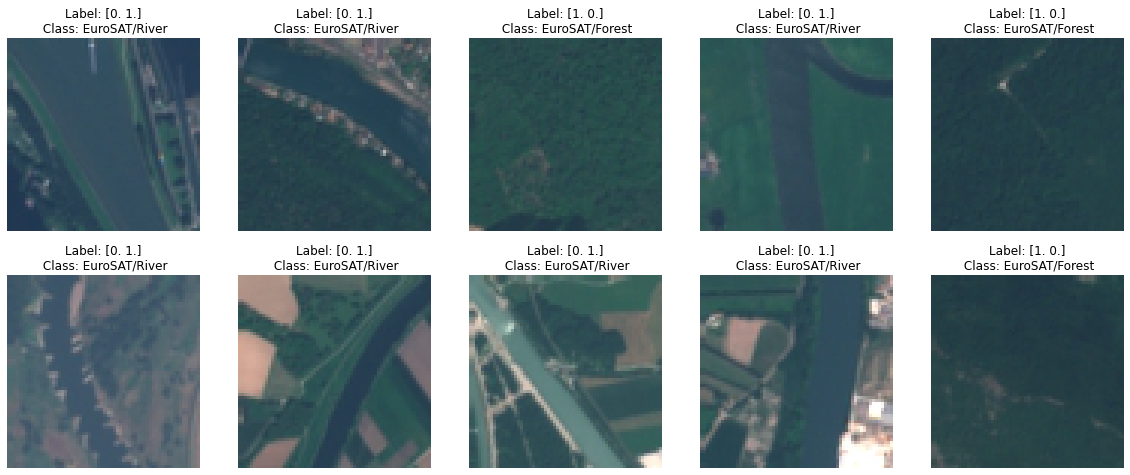

In [8]:
plotDataset(train_images, train_labels, datasetHandler.classes, 5, 2)

## CNN classifier

In [9]:
from CNN_Classifier import CNN_Classifier

### 1. Initialize the CNN model

In [10]:
img_shape = plt.imread(train_images[0]).shape
n_classes = train_labels.shape[1]

cnn = CNN_Classifier(img_shape = img_shape, n_classes = n_classes)

In [11]:
cnn.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 3)         228       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0

### 2. Train the CNN model

In [12]:
batch_size = 16
epochs = 20
train_generator = datasetHandler.cnn_data_loader(train_images, train_labels, batch_size = batch_size, img_shape = img_shape, n_classes = n_classes)
val_generator = datasetHandler.cnn_data_loader(val_images, val_labels, batch_size = batch_size, img_shape = img_shape, n_classes = n_classes)

history = cnn.train_model(epochs, batch_size, train_generator, val_generator, len(train_images), len(val_images))

Epoch 1/20
275/275 [==============================] - 9s 30ms/step - loss: 0.6764 - accuracy: 0.5281 - val_loss: 0.4867 - val_accuracy: 0.9246
Epoch 2/20
275/275 [==============================] - 7s 24ms/step - loss: 0.3719 - accuracy: 0.9176 - val_loss: 0.1983 - val_accuracy: 0.9292
Epoch 3/20
275/275 [==============================] - 7s 25ms/step - loss: 0.2050 - accuracy: 0.9351 - val_loss: 0.1478 - val_accuracy: 0.9494
Epoch 4/20
275/275 [==============================] - 7s 25ms/step - loss: 0.1515 - accuracy: 0.9477 - val_loss: 0.1567 - val_accuracy: 0.9283
Epoch 5/20
275/275 [==============================] - 7s 25ms/step - loss: 0.1423 - accuracy: 0.9514 - val_loss: 0.1196 - val_accuracy: 0.9605
Epoch 6/20
275/275 [==============================] - 7s 25ms/step - loss: 0.1337 - accuracy: 0.9528 - val_loss: 0.1003 - val_accuracy: 0.9642
Epoch 7/20
275/275 [==============================] - 7s 24ms/step - loss: 0.1173 - accuracy: 0.9582 - val_loss: 0.1061 - val_accuracy: 0.9596

#### After training the CNN model, save it in the trained_models folder

In [13]:
cnn.model.save(os.path.join('trained_models', 'CNN-' + classes_name[0] + '-VS-' + classes_name[1] + '.h5'))

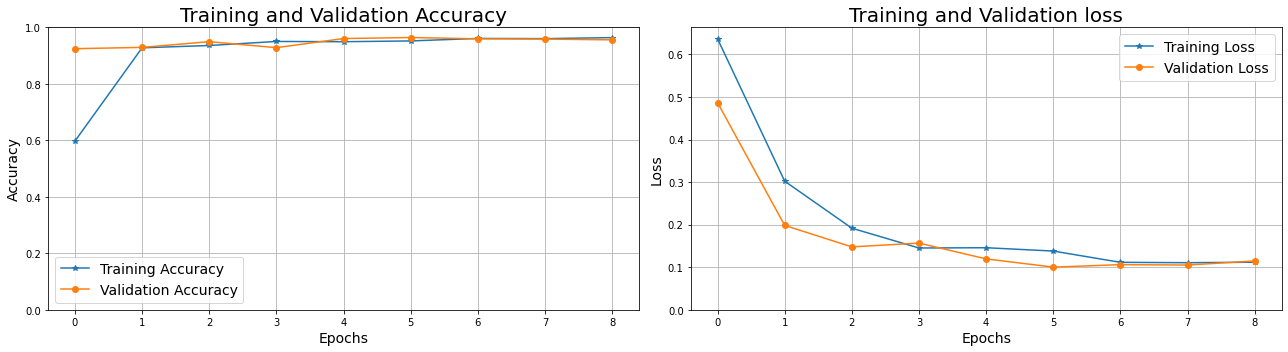

In [17]:
from utils import plotCNNhistory
plotCNNhistory(history)

### 3. Test the CNN model

In [18]:
from sklearn.metrics import confusion_matrix
from utils import reverseOneHotEncoding

In [19]:
x_train, y_train = next(iter(datasetHandler.cnn_data_loader(val_images, val_labels, batch_size = len(val_images), img_shape = img_shape, n_classes = n_classes)))
pred = cnn.model.predict(x_train)

pl = reverseOneHotEncoding(pred, classes_name)
cl = reverseOneHotEncoding(y_train, classes_name)

cm = confusion_matrix(pl, cl)#, classes_name)


# correct predictions / samples * 100
accuracy = (cm[0,0] + cm[1,1]) / sum(sum(cm)) * 100
print('Accuracy: ', accuracy)

Accuracy:  96.63636363636363


## QCNN Classifier

In [9]:
from QCNN_Classifier import QCNN_Classifier

### 1. Initialize the model

In [10]:
qcnn = QCNN_Classifier()

In [12]:
img_shape = plt.imread(train_images[0]).shape
n_classes = train_labels.shape[1]
epochs = 20

train_generator = datasetHandler.qcnn_data_loader(train_images, train_labels, batch_size = 1, img_shape = img_shape)
loss_list = qcnn.train_model(epochs, train_generator, len(train_images))

 ->  Training [5%]	Loss: -0.7639


KeyboardInterrupt: 

In [ ]:
val_data_gen = datasetHandler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = img_shape)
qcnn.evaluate_model(val_data_gen, len(val_images))

# Running all the binary classification tests

In [161]:
run = False

if run:
    cnn = np.zeros((10, 10))
    qcnn4eo = np.zeros((10, 10))
    
    for i in range(8):
        print(classes_name[i]+ ' ' + str(i) + ' VS ')
        for j in range(9):
            if i!=j and j>i:
                #print('Train CNN')
                #print('Test CNN')
                #print('Test QCNN4O')
                #print('Test QCNN4O')
                #print(j, end='')
                print('             -> ' + str(j) + ' ' + classes_name[j])
            elif i==j:
                cnn[i,j] = np.nans
                qcnn4eo[i,j] = np.nan
else:
    # Load the tests (see the paper)
    cnn = np.array([
    [np.nan,	95.1,	99.3,	94.1,	99.3,	98.8,	98.6,	98.8,	96.5,	95.2],
    [95.1,	np.nan,	95.7,	94.5,	89.9,	78.2,	92.4,	99.0,	77.0,	86.6],
    [99.3,	95.7,	np.nan,	99.9,	95.6,	96.1,	87.7,	96.9,	99.5,	99.1],
    [94.1,	94.5,	99.9,	np.nan,	98.5,	96.8,	99.9,	99.9,	97.5,	94.1],
    [99.3,	89.9,	95.6,	98.5,	np.nan,	90.1,	89.7,	98.8,	87.5,	83.3],
    [98.8,	78.2,	96.1,	96.8,	90.1,	np.nan,	90.8,	95.3,	91.9,	92.8],
    [98.6,	92.4,	87.7,	99.9,	89.7,	90.8,	np.nan,	93.0,	87.5,	93.5],
    [98.8,	99.0,	96.9,	99.9,	98.8,	95.3,	93.0,	np.nan,	98.2,	96.9],
    [96.5,	77.0,	99.5,	97.5,	87.5,	91.9,	87.5,	98.2,	np.nan,	73.7],
    [95.2,	86.6,	99.1,	94.1,	83.3,	92.8,	93.5,	96.9,	73.7,	np.nan]])

    qcnn4eo = np.array([
    [np.nan,	95.5,	99.8,	93.5,	99.3,	98.3,	99.7,	99.7,	97.8,	95.3],
    [95.5,	np.nan,	99.5,	95.3,	93.4,	85.4,	94.6,	98.6,	82.7,	87.5],
    [99.8,	99.5,	np.nan,	99.9,	94.7,	97.4,	86.6,	97.9,	99.3,	97.9],
    [93.5,	95.3,	99.9,	np.nan,	98.7,	97.5,	99.9,	99.9,	98.2,	97.4],
    [99.3,	93.4,	94.7,	98.7,	np.nan,	91.6,	91.8,	91.9,	87.4,	94.3],
    [98.3,	85.4,	97.4,	97.5,	91.6,	np.nan,	90.2,	96.1,	93.9,	92.2],
    [99.7,	94.6,	86.6,	99.9,	91.8,	90.2,	np.nan,	95.1,	89.4,	96.0],
    [99.7,	98.6,	97.9,	99.9,	91.9,	96.1,	95.1,	np.nan,	98.9,	98.0],
    [97.8,	82.7,	99.3,	98.2,	87.4,	93.9,	89.4,	98.9,	np.nan,	75.0],
    [95.3,	87.5,	97.9,	97.4,	94.3,	92.2,	96.0,	98.0,	75.0,	np.nan]])

In [153]:
classes_name = np.array(["Residential", "Highway", "Sea Lake", "Industrial", "Annual Crop", "River", "Pasture",	"Forest", "Permanent Crop", "Herbaceous Vegetation"])

min_val = np.min([np.min(np.min(cnn[cnn>0])), np.min(np.min(qcnn4eo[qcnn4eo>0]))])
max_val = np.max([np.max(np.max(cnn[cnn>0])), np.max(np.max(qcnn4eo[qcnn4eo>0]))])

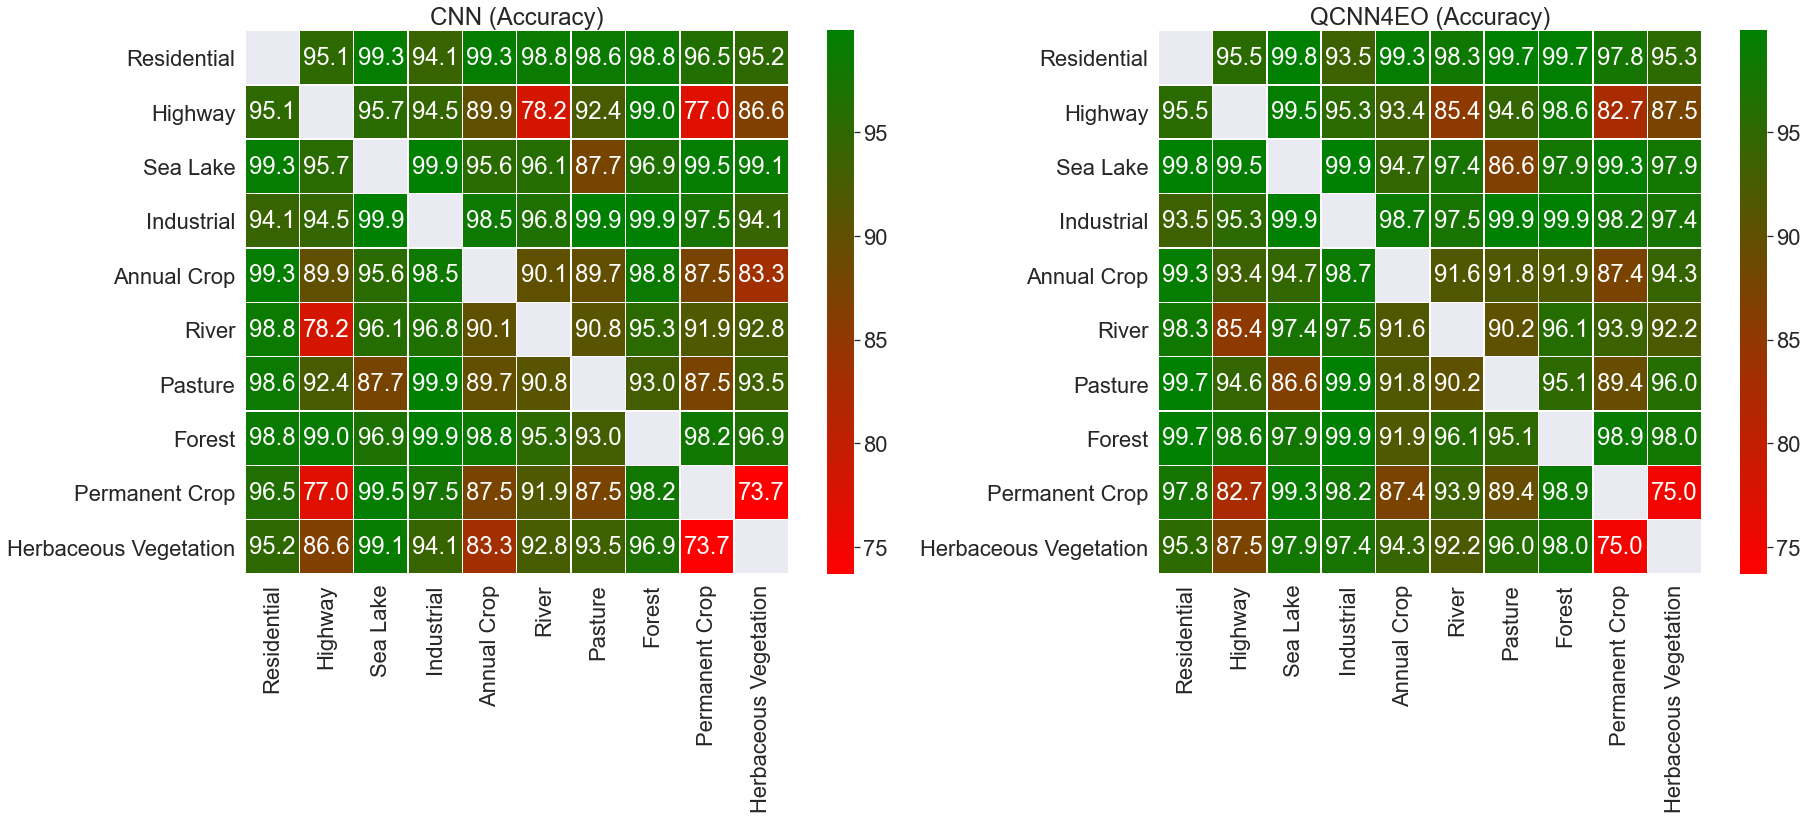

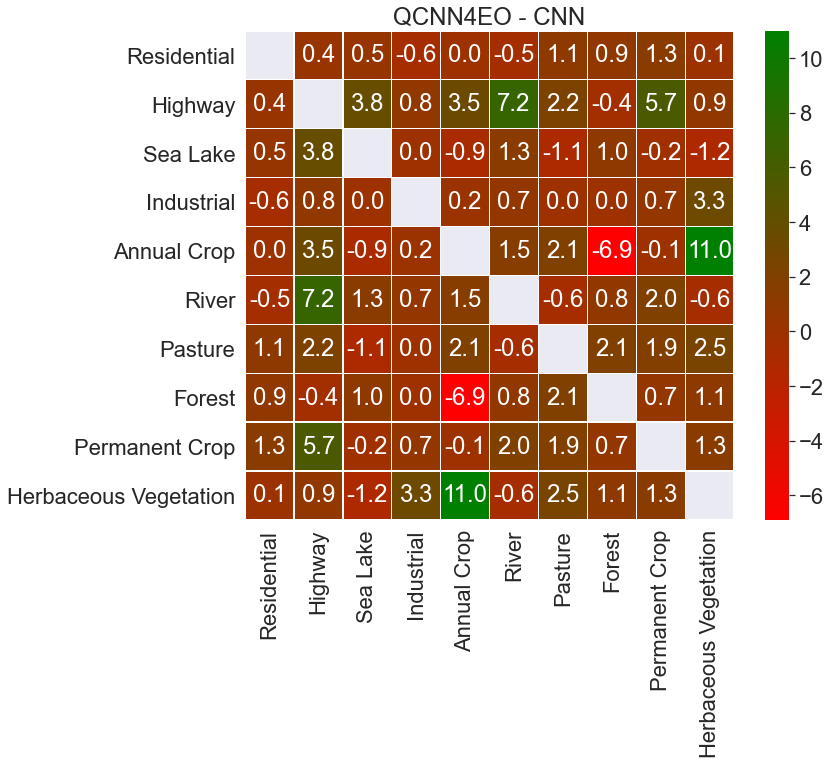

In [154]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list(
    name='red-green', 
    colors=['red','green']
)

sns.set(font_scale=2)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 10))
sns.heatmap(cnn, linewidth=0.5, fmt='.1f', vmin = min_val, vmax = max_val, square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = axes[0]).set(title='CNN (Accuracy)')
sns.heatmap(qcnn4eo, linewidth=0.5, fmt='.1f', vmin = min_val, vmax = max_val, square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = axes[1]).set(title='QCNN4EO (Accuracy)')
plt.show()


fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (11, 9))
sns.heatmap(qcnn4eo - cnn, linewidth=0.5, fmt='.1f', square = True, cmap = cmap, 
            annot = True, xticklabels = classes_name, yticklabels = classes_name, ax = ax).set(title='QCNN4EO - CNN')
plt.show()

In [21]:
!code .